In [1]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstal

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchattacks

import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import uniform_direction

from sklearn.metrics import roc_curve, accuracy_score

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

### IMPORT MNIST DATASET

# trainloader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.1307,), (0.3081,)),
#             ])),
#         batch_size=64, shuffle=True)

# testloader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.1307,), (0.3081,)),
#             ])),
#         batch_size=64, shuffle=True)

# classes = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")

### IMPORT FASHION MNIST DATASET

trainloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485,), (0.229,)),
            ])),
        batch_size=64, shuffle=True)

testloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485,), (0.229,)),
            ])),
        batch_size=64, shuffle=True)

classes = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

model = Net()

100%|██████████| 26421880/26421880 [00:01<00:00, 17384634.82it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271257.53it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4934650.82it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19244453.65it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [5]:
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# TRAIN MODEL

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [7]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 1.054
[1,   200] loss: 0.653
[1,   300] loss: 0.574
[1,   400] loss: 0.541
[1,   500] loss: 0.519
[1,   600] loss: 0.479
[1,   700] loss: 0.448
[1,   800] loss: 0.446
[1,   900] loss: 0.425
[2,   100] loss: 0.391
[2,   200] loss: 0.370
[2,   300] loss: 0.399
[2,   400] loss: 0.361
[2,   500] loss: 0.345
[2,   600] loss: 0.370
[2,   700] loss: 0.343
[2,   800] loss: 0.337
[2,   900] loss: 0.361
[3,   100] loss: 0.321
[3,   200] loss: 0.325
[3,   300] loss: 0.309
[3,   400] loss: 0.304
[3,   500] loss: 0.313
[3,   600] loss: 0.309
[3,   700] loss: 0.300
[3,   800] loss: 0.289
[3,   900] loss: 0.300
[4,   100] loss: 0.261
[4,   200] loss: 0.273
[4,   300] loss: 0.278
[4,   400] loss: 0.263
[4,   500] loss: 0.271
[4,   600] loss: 0.274
[4,   700] loss: 0.274
[4,   800] loss: 0.272
[4,   900] loss: 0.281
Finished Training


In [8]:
PATH = './mnist_net.pth'
torch.save(model.state_dict(), PATH)

# SEE MODEL's PERFS

In [9]:
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 91 %


In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: T-shirt/top is 87.0 %
Accuracy for class: Trouser is 97.6 %
Accuracy for class: Pullover is 82.7 %
Accuracy for class: Dress is 93.4 %
Accuracy for class: Coat  is 89.7 %
Accuracy for class: Sandal is 98.9 %
Accuracy for class: Shirt is 70.8 %
Accuracy for class: Sneaker is 97.0 %
Accuracy for class: Bag   is 98.2 %
Accuracy for class: Ankle boot is 95.5 %


In [12]:
IMG_SHAPE = (1, 28, 28)
IMG_DIM = IMG_SHAPE[0]*IMG_SHAPE[1]*IMG_SHAPE[2]

# DEFINE UTIL FUNCTIONS

In [13]:
def compute_grad(input, reference_label, i = None):
  """
  Computes gradient of f_{reference_label}(input) - f_i(input)
  """
  model.zero_grad()
  input = torch.tensor(input, requires_grad=True)
  output = model(input)
  if i is None:
    g = torch.zeros((10, input.size(0)) + IMG_SHAPE)
    for i in range(10):
      g[i] = torch.autograd.grad(output[:, i].sum(), input, retain_graph=True)[0].data
    return g[reference_label] - g
  else:
    g_i = torch.autograd.grad(output[:, i].sum(), input, retain_graph=True)[0].data
    return torch.autograd.grad(output[:, reference_label].sum(), input, retain_graph=True)[0].data - g_i

In [14]:
def project_orth(v, n):
  """
  Computes projection of v on the hyperplane orthogonal to n
  - n is a normal vector
  """
  return v - torch.einsum("vi, ki, kj -> kvj", v, n, n)

In [15]:
# List of unit vectors of R(N^3)
v_unit = torch.stack([
    (torch.arange(IMG_DIM) == i).float()
    for i in range(IMG_DIM)
])

def compute_hess(x, reference_label, grad_x, h = 1e-2, v_unit = v_unit):
  """
  Computes the hessian of f_{reference_label}(x) - f_i(x)
  - grad_x : an array containing all the i gradients f_{reference_label}(x) - f_i(x)
  - h : a small real value
  - v_unit : reference vectors to compute the coeffs of the hessian
  """
  hess = torch.zeros((10, IMG_DIM, IMG_DIM))

  for i in range(10):
    grad = grad_x[i]

    if len(v_unit.size()) == 3:
      v = v_unit[i]
    else:
      v = v_unit

    v_shaped = v.reshape((v.size(0),) + IMG_SHAPE)

    x_dx = x + h*v_shaped

    grad_x_dx = compute_grad(
        x_dx,
        reference_label,
        i,
    ).reshape((v.size(0), IMG_DIM))

    hess_v = (grad_x_dx - grad)/h

    v_hess_v = torch.einsum("im, jm -> ij", v, hess_v)
    hess[i, :] = v_hess_v

  return hess

In [16]:
def compute_principal_curvatures(image, label, h = 1e-2):
    """
    Computes the principal curvatures of the decision boundaries of given
    image with given label, w.r.t. the 9 other labels
    - h : a small real value
    """
    gradient = compute_grad(image, label).reshape((10, IMG_DIM))
    gradient_norm = torch.norm(gradient, dim=1)
    proj_v_unit = project_orth(v_unit, gradient / gradient_norm.reshape((-1, 1)))
    hessian = compute_hess(image, label, gradient, h, proj_v_unit)
    print(hessian.shape)

    return [
        torch.linalg.eigvalsh(hessian[j]) / gradient_norm[j] if j != label else None
        for j in range(10)
    ]

In [17]:
 def compute_mean_curvature(image, label, h = 1e-2):
    """
    Computes the mean curvature of the decision boundaries of given
    image with given label, w.r.t. the 9 other labels
    - h : a small real value
    """
    gradient = compute_grad(image, label).reshape((10, IMG_DIM))
    gradient_norm = torch.norm(gradient, dim=1)

    hessian = compute_hess(image, label, gradient, h, v_unit)

    gradient_curv = torch.einsum("ki, kij, kj -> k", gradient, hessian, gradient)
    gradient_curv /= 2 * gradient_norm**3

    trace_curv = torch.einsum("kii -> k", hessian)
    trace_curv /= 2 * gradient_norm

    return gradient_curv - trace_curv

In [18]:
def run_to_boundary(image, reference_label, dir, h, k_max):
  """
  Computes the precise point of intersection of {image} + t x {dir}
  with (any) decision boundary
  - h : the initial step size from image towards dir
  - k_max : output precision will be of h x 10 ^ (- k_max)
  """
  new_image = image
  k = 0
  while True:
    output = model(new_image.reshape((1,) + IMG_SHAPE))[0]
    label = torch.argmax(output)

    if label != reference_label and k == k_max:
      return image, label

    elif label != reference_label:
      k += 1

    else:
      image = new_image

    new_image = image + h * 10**(-k) * dir

In [19]:
def run_orth_gradient(image, reference_label, u, v, n, h):
  """
  Computes the intersection line between the decision boundary of
  class {reference_label} passing through {image}, and the plane defined
  by the vectors {u} and {v}.
  - h : step size (between the points)
  - n : number of points computed from {image}, in both directions
  """
  points = torch.zeros((2*n + 1,) + IMG_SHAPE)
  points[n] = image
  deltas = torch.zeros((2*n + 1, 2))
  outputs = torch.zeros((2*n + 1, 10))
  outputs[n] = model(points[n:(n+1)])[0]

  for sign in [-1, 1]:

    for i in range(n):
      output = model(points[n+sign*i:(n+sign*i+1)])[0]
      outputs[n+sign*(i+1)] = output

      sorted_labels = torch.argsort(output, descending = True)
      if sorted_labels[0] == reference_label:
        label = sorted_labels[1]
      else:
        label = sorted_labels[0]

      g = compute_grad(points[n+sign*i:(n+sign*i+1)], reference_label, label)
      g_u = torch.dot(u, g.flatten())
      g_v = torch.dot(v, g.flatten())

      if torch.sign(g_u) == sign:
        delta = g_u * v - g_v * u
        deltas[n+sign*(i+1)] = deltas[n+sign*i] + torch.tensor([-g_v, g_u]) * h / torch.norm(delta)
      else:
        delta = g_v * u - g_u * v
        deltas[n+sign*(i+1)] = deltas[n+sign*i] + torch.tensor([g_v, -g_u]) * h / torch.norm(delta)

      delta *= h / torch.norm(delta)

      points[n+sign*(i+1)] = points[n+sign*i] + delta.reshape(IMG_SHAPE)
  return points, deltas, outputs


# COMPUTE AVERAGE CURVATURE

In [ ]:
curv = []
dataiter = iter(testloader)
h = 1e-1

for xs, _ in dataiter:
  labels = torch.argmax(model(xs), axis = 1)
  for i in range(len(xs)):
    x = xs[i:(i+1)]
    label = labels[i]

    if label.item() != 0:
      continue

    curv.append(compute_principal_curvatures(x, label, h))

    if len(curv) == 1:
      break
  else:
    continue
  break

<ipython-input-28-c8f09c0898bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, requires_grad=True)


torch.Size([10, 784, 784])


In [ ]:
np.save("./curv_sample_40_reference_label_0.npy", np.array([[x[i].numpy() for i in range(1, 10)] for x in curv]))
curv = np.load("./curv_sample_40_reference_label_0.npy")

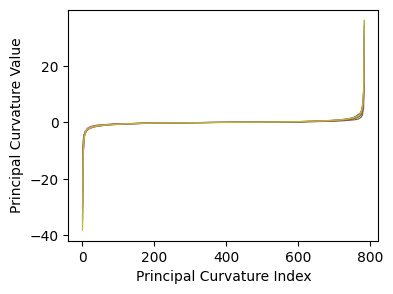

In [ ]:
plt.figure(figsize=(4, 3))
[plt.plot(np.mean(np.array([x[i] for x in curv]), axis = 0), linewidth = 0.8, label =f'0-{i+1}') for i in range(9)]
plt.xlabel("Principal Curvature Index")
plt.ylabel("Principal Curvature Value")
plt.show()

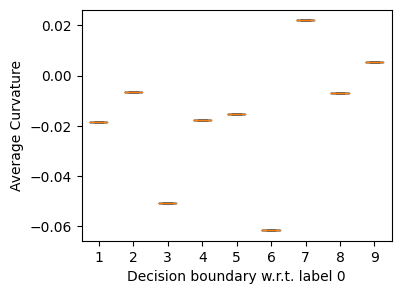

In [ ]:
plt.figure(figsize=(4, 3))
plt.boxplot([np.mean(np.array([x[i] for x in curv]), axis = 1) for i in range(9)])
plt.xlabel('Decision boundary w.r.t. label 0')
plt.ylabel('Average Curvature')
plt.show()

# PLOT DECISION BOUNDARY

In [ ]:
# v = torch.Tensor(uniform_direction.rvs(dim=IMG_DIM))

In [20]:
dataiter = iter(testloader)
h = 1e-3
atk2 = torchattacks.PGD(model, eps=16/255, alpha=2/255, steps=40, random_start=True)
atk2.set_normalization_used(mean=[0.485,], std=[0.229,])
# use mean=[0.485,], std=[0.229,] for fashion MNIST
# use mean=[0.1307,], std=[0.3081,] for MNIST

for xs, _ in dataiter:
  labels = torch.argmax(model(xs), axis = 1)
  for i in range(len(xs)):
    x = xs[i:(i+1)]
    label = labels[i]

    y_0 = atk2(x, labels[i:(i+1)])
    print(classes[label.item()], classes[torch.argmax(model(y_0)[0]).item()])
    print("Starting perturbation :")
    print("l2   :", torch.norm(y_0-x))
    print("linf :", torch.max(torch.abs(y_0-x)))

    y, boundary_label = run_to_boundary(x, label, y_0-x, 1e-2, 3)

    g = compute_grad(y, label, boundary_label)
    g /= torch.norm(g)
    g = g.flatten()

    u = (y-x).flatten().dot(g) * g
    u_norm = u / torch.norm(u)

    v = (y-x).flatten() - u
    v_norm = v / torch.norm(v)


    print("Obtained boundary point :")
    print("l2   :", torch.norm(y-x))
    print("linf :", torch.max(torch.abs(y-x)))

    points, deltas, outputs = run_orth_gradient(y, label, u_norm, v_norm, 400, 3e-2)
    points2, deltas2, outputs2 = run_orth_gradient(x, label, u_norm, v_norm, 400, 3e-2)
    points3, deltas3, outputs3 = run_orth_gradient(y_0, label, u_norm, v_norm, 400, 3e-2)

    plt.figure(figsize=(5, 5))
    plt.scatter(x = 0, y = 0, c = "green", marker = "x", label = f"$x$, label {classes[label.item()]}")
    plt.scatter(x = torch.norm(u) * torch.norm(y_0-x) / torch.norm(y-x), y = torch.norm(v) * torch.norm(y_0-x) / torch.norm(y-x), c = "red", marker = "x", label = f"$y$, label {classes[torch.argmax(model(y_0)[0]).item()]}")
    plt.scatter(x = torch.norm(u), y = torch.norm(v), c = "black", marker = "x", label = f"$z$, lying on the decision boundary")
    plt.scatter(x = torch.norm(u) + deltas[:, 0], y = torch.norm(v) + deltas[:, 1], s = 0.1, c="black")
    plt.scatter(x = deltas2[:, 0], y = deltas2[:, 1], s = 0.01, c="#adadad")
    plt.scatter(x = torch.norm(u) * torch.norm(y_0-x) / torch.norm(y-x) + deltas3[:, 0], y = torch.norm(v) * torch.norm(y_0-x) / torch.norm(y-x) + deltas3[:, 1], s = 0.01, c="#adadad")
    plt.legend()
    plt.ylabel("$(z-x) - p_n(z-x)$")
    plt.xlabel("$n$")
    plt.show()
    plt.plot(outputs.detach().numpy()[:,:label])
    plt.plot(outputs.detach().numpy()[:,(label+1):])
    plt.plot(outputs.detach().numpy()[:,label], color = "black", linestyle = "--")
    plt.show()
    plt.imshow(points[0,0])
    plt.show()
    plt.imshow(points[-1,0])
    plt.show()

  break

Output hidden; open in https://colab.research.google.com to view.

## Analyze dependency of curvature computations w.r.t. the parameter h

In [ ]:
curv = []
dataiter = iter(testloader)
for xs, _ in dataiter:
  labels = torch.argmax(model(xs), axis = 1)
  for i in range(len(xs)):
    x = xs[i:(i+1)]
    label = labels[i]

    if label.item() != 0:
      continue

    curv.append(compute_principal_curvatures(x, label, 1e1))
    # curv.append(compute_principal_curvatures(x, label, 1e0))
    curv.append(compute_principal_curvatures(x, label, 1e-1))
    # curv.append(compute_principal_curvatures(x, label, 1e-2))
    curv.append(compute_principal_curvatures(x, label, 1e-3))
    # curv.append(compute_principal_curvatures(x, label, 1e-4))
    curv.append(compute_principal_curvatures(x, label, 1e-5))
    # curv.append(compute_principal_curvatures(x, label, 1e-6))
    curv.append(compute_principal_curvatures(x, label, 1e-7))
    # curv.append(compute_principal_curvatures(x, label, 1e-8))
    curv.append(compute_principal_curvatures(x, label, 1e-9))
    break
  break

[24.002209, 337.6737, 10337.634, 469788.44, 26221824.0, 31999.125]


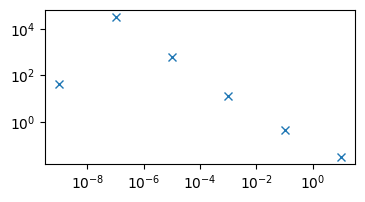

In [ ]:
print([np.sum(np.abs((y[1].numpy()))) for y in curv])

plt.figure(figsize=(4, 2))
plt.plot(
    [10**k for k in range(1,-10, -2)],
    [np.mean(np.abs(x.numpy())) for i, y in enumerate(curv) for x in y[1:2] if x is not None],
    linestyle = " ",
    marker="x",
)
plt.xscale("log")
plt.yscale("log")
plt.show()

# PERFORM ATTACK

In [ ]:
atk1 = torchattacks.FGSM(model, eps=16/255)
atk2 = torchattacks.PGD(model, eps=16/255, alpha=2/255, steps=40, random_start=True)
atk1.set_normalization_used(mean=[0.485,], std=[0.229,])
atk2.set_normalization_used(mean=[0.485,], std=[0.229,])
# use mean=[0.485,], std=[0.229,] for fashion MNIST
# use mean=[0.1307,], std=[0.3081,] for MNIST

In [ ]:
results_atk = []
results_avg = []
results_prd = []
for data, labels in testloader:
  for i in range(len(data)):
    image = data[i:i+1]
    label = labels[i:i+1]
    adv_images_atk1 = atk1(image, label)
    adv_images_atk2 = atk2(image, label)

    label_atk1 = torch.argmax(model(adv_images_atk1), dim = 1)
    label_atk2 = torch.argmax(model(adv_images_atk2), dim = 1)

    print(classes[int(label[0])], classes[int(label_atk1[0])], classes[int(label_atk2[0])])

    if label_atk2 == label:
      print("FAILED ATTACK")
      results_atk.append(False)
      continue

    results_atk.append(True)

    avg_curvs = compute_mean_curvature(image, label, h = 1e-1)
    avg_curvs_atk2 = compute_mean_curvature(adv_images_atk2, label_atk2, h = 1e-1)

    results_avg.append((torch.nansum(avg_curvs).detach(), torch.nansum(avg_curvs_atk2).detach()))
    results_prd.append(torch.where(torch.argsort(avg_curvs_atk2, descending = True) == label))

    for i in range(10):
      if avg_curvs[i] is None:
        print(f"{i} // Original : None       // Adversarial : {avg_curvs_atk2[i]:<10.2f}")
      elif avg_curvs_atk2[i] is None:
        print(f"{i} // Original : {avg_curvs[i]:<10.2f} // Adversarial : None")
      else:
        print(f"{i} // Original : {avg_curvs[i]:<10.2f} // Adversarial : {avg_curvs_atk2[i]:<10.2f}")

    if np.sum(np.array(results_atk)) == 50:
      break
  else:
    continue
  break

Sandal Sandal Ankle boot


<ipython-input-14-7f814c6abdbc>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, requires_grad=True)


0 // Original : 32.87      // Adversarial : 26.42     
1 // Original : 23.21      // Adversarial : 22.12     
2 // Original : 24.39      // Adversarial : 30.04     
3 // Original : 29.52      // Adversarial : 20.41     
4 // Original : 27.34      // Adversarial : 25.72     
5 // Original : nan        // Adversarial : 20.30     
6 // Original : 31.61      // Adversarial : 32.00     
7 // Original : 28.08      // Adversarial : 11.71     
8 // Original : 43.52      // Adversarial : 26.39     
9 // Original : 27.91      // Adversarial : nan       
Bag Bag Bag
FAILED ATTACK
Bag Bag Shirt
0 // Original : 9.41       // Adversarial : 3.81      
1 // Original : 4.08       // Adversarial : 14.88     
2 // Original : 11.55      // Adversarial : 12.10     
3 // Original : 1.35       // Adversarial : 16.83     
4 // Original : 8.42       // Adversarial : 11.77     
5 // Original : -0.09      // Adversarial : 9.06      
6 // Original : 20.50      // Adversarial : nan       
7 // Original : 2.19     

In [ ]:
results_avg = [(x[0].item(), x[1].item()) for x in results_avg]
# results_avg = [
#     (88.01141357421875, 86.07658386230469),(10.042008399963379, 144.98829650878906),(-67.92420959472656, 72.25010681152344),
#     (100.33119201660156, 94.4207763671875),(-1.675331473350525, 170.9068145751953),(96.31214904785156, 72.709716796875),
#     (83.91546630859375, 94.9438247680664),(56.7227668762207, 122.79318237304688),(124.150634765625, 86.24434661865234),
#     (-16.628314971923828, 154.20030212402344),(-4.294841766357422, 77.63740539550781),(14.892765045166016, 118.83946990966797),
#     (98.43080139160156, 81.9873275756836),(-103.98602294921875, 88.69100952148438),(31.966838836669922, 120.79067993164062),
#     (29.44173240661621, 92.5682373046875),(-56.97701644897461, 69.8331527709961),(-88.05496978759766, 183.3270721435547),
#     (-87.18688201904297, 115.83625793457031),(12.667649269104004, 124.97571563720703),(-50.53786849975586, 196.59872436523438),
#     (-66.11328887939453, 134.64724731445312),(24.542564392089844, 70.28812408447266),(23.41132926940918, 102.29246520996094),
#     (222.64813232421875, 97.79672241210938),(127.74127197265625, 14.924882888793945),(-5.529287338256836, 69.52275848388672),
#     (-81.30110931396484, 177.03036499023438),(70.6497802734375, 80.20277404785156),(164.04989624023438, 75.87069702148438),
#     (46.96733856201172, 131.330078125),(148.48648071289062, 76.92330169677734),(-13.4327974319458, 129.9555206298828),
#     (80.95709228515625, 92.97488403320312),(37.33037567138672, 131.3566131591797),(65.37023162841797, 132.98968505859375),
#     (64.58399963378906, 111.45770263671875),(26.624177932739258, 111.29505920410156),(-62.77639389038086, 86.68759155273438),
#     (172.80413818359375, 74.48714447021484),(-13.484124183654785, 89.99364471435547),(1.2259466648101807, 85.4403076171875),
#     (64.02574920654297, 39.84731674194336),(122.03719329833984, 111.17839050292969),(91.5855484008789, 127.69110870361328),
#     (-27.505844116210938, 93.94317626953125),(-109.48824310302734, 151.03713989257812),(152.4801483154297, 112.7501220703125),
#     (118.44203186035156, 78.55879974365234),(-21.831748962402344, 121.50883483886719)
# ]
# for MNIST

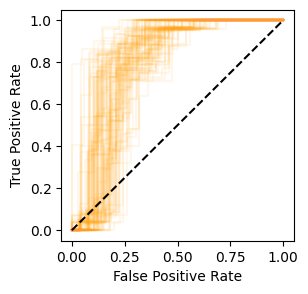

In [ ]:
plt.figure(figsize=(3, 3))
for k in range(100):
  perturbed_indices = np.random.choice(50, 25, replace=False)
  y_pred = []
  y_true = []
  for j, z in enumerate(results_avg):
    i = np.random.randint(2) # j in perturbed_indices
    y_pred.append(z[i])
    y_true.append(i)
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)

  plt.plot(fpr, tpr, alpha = 0.08, color = "orange")

plt.plot([0., 1.], [0., 1.], color = "black", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

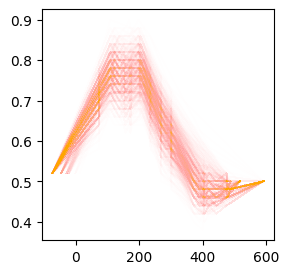

In [ ]:
plt.figure(figsize=(3, 3))
from sklearn.metrics import roc_curve, accuracy_score
for k in range(1000):
  perturbed_indices = np.random.choice(50, 25, replace=False)
  y_pred = []
  y_true = []
  for j, z in enumerate(results_avg):
    i = j in perturbed_indices
    y_pred.append(z[i])
    y_true.append(i)
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)

  accuracy_scores = []
  for thresh in thresholds:
      accuracy_scores.append(accuracy_score(y_true, [m > thresh for m in y_pred]))
  accuracies = np.array(accuracy_scores)

  plt.plot(thresholds, accuracies, alpha = 0.002, color = "orange")

plt.show()

In [ ]:
sum(results_atk) / len(results_atk)

0.8620689655172413

In [ ]:
results_prd = [x[0].item() for x in results_prd]
# results_prd = [1,5,1,1,2,3,6,2,5,5,1,1,1,1,2,1,1,2,1,1,2,1,1,1,2,1,1,6,1,4,1,2,1,1,1,1,2,1,1,1,1,1,1,1,3,1,2,1,1,1]
# for MNIST

NameError: ignored

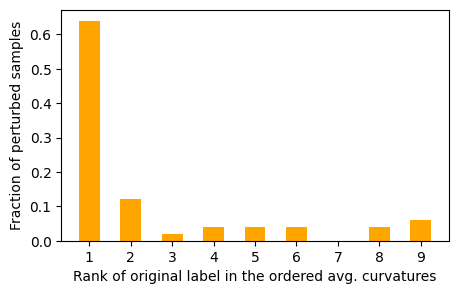

In [ ]:
plt.figure(figsize=(5,3))
plt.hist(results_prd, bins = np.arange(10) + 0.5, density=True, rwidth=0.5, color = "orange")
plt.xticks(np.arange(1, 10))
plt.xlabel("Rank of original label in the ordered avg. curvatures")
plt.ylabel("Fraction of perturbed samples")
plt.show()